In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance as dist
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import cm

# Define functions: Kernel, interpolation

Kernel function

In [12]:
def phi(const, point, point_n):
    result = np.exp(- const * dist.euclidean(point, point_n) ** 2)
    return result

Interpolation function

In [13]:
def intpl_func(point_x, point_y, centre, weight, const):
    mat = weight.ravel() * np.exp(- const * ((point_x - centre[:,0]) ** 2 + (point_y - centre[:,1]) ** 2))
    return sum(mat)

# Determine parameters

In [14]:
start_fr = 200 # start frame
end_fr = start_fr + 1 # end frame
const = 1 # constant in kernel
scaling = 0.01 # scaling of position vectors in data
weight = 1.5 # weight of IQR method
grid_number_x = 50 # dense of x-axis grid for plotting interpolated functions
grid_number_y = 50

# Data processing

Read data, and screen data for the particular frames

In [15]:
data = pd.read_csv('MOT16-04.csv')
df = data.loc[:,['frame_id','pedestrianId','Xt','Yt']]

start_df = df.loc[(df['frame_id'] == start_fr)]
end_df = df.loc[(df['frame_id'] == end_fr)]

Find same ped_id in start/end frames and calculate position/speed vectors and norm

In [16]:
df = pd.merge(start_df, end_df, on = 'pedestrianId', suffixes = ('_s', '_e'))
df[['Xt_s','Yt_s','Xt_e','Yt_e']] = df[['Xt_s','Yt_s','Xt_e','Yt_e']] * scaling

U = pd.Series(df.loc[:, 'Xt_e'] - df.loc[:, 'Xt_s'], name = 'U')
V = pd.Series(df.loc[:, 'Yt_e'] - df.loc[:, 'Yt_s'], name = 'V')
Norm = pd.Series((U ** 2 + V ** 2) ** 0.5, name = 'Norm')

df = pd.concat([df.loc[:, ['pedestrianId', 'Xt_s', 'Yt_s']], U, V, Norm], axis = 1)

Remove outliers from norm, by the IQR method

In [17]:
quantile_25 = np.percentile(df['Norm'], 25)
quantile_75 = np.percentile(df['Norm'], 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR * weight

lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

ini_vector = df.loc[(df['Norm'] >= lowest) & (df['Norm'] <= highest)]

# Calculate interpolation function

Calculate weight of interpolation functions(k-neighbourhood)

In [18]:
ini_xy = ini_vector.loc[:,['Xt_s','Yt_s']].values
ini_u = ini_vector.loc[:,['U']].values
ini_v = ini_vector.loc[:,['V']].values

k = 2 # the number of points in k-neighbourhood

phi_array = np.zeros((len(ini_xy), len(ini_xy)))
for i in range(len(ini_xy)):
    col_dist = ((ini_xy[:,0] - ini_xy[i][0]) ** 2 + (ini_xy[:,1] - ini_xy[i][1]) ** 2) ** 0.5
    ini_dist = np.c_[ini_xy, col_dist]
    dist_sort_index = ini_dist[:,2].argsort()
    nei_index = dist_sort_index[0:k]
    
    for j in range(len(nei_index)):
        phi_array[i][nei_index[j]] = phi(const, ini_xy[i][0:2], ini_xy[nei_index[j]][0:2])

weight_x = spsolve(csc_matrix(phi_array), csc_matrix(ini_u))
weight_y = spsolve(csc_matrix(phi_array), csc_matrix(ini_v))

Calculate interpolation functions

In [19]:
min_x = min(ini_xy[:,0])
max_x = max(ini_xy[:,0])
min_y = min(ini_xy[:,1])
max_y = max(ini_xy[:,1])

grid_x0 = np.linspace(min_x - (100 * scaling), max_x + (100 * scaling), grid_number_x)
grid_y0 = np.linspace(min_y - (100 * scaling), max_y + (100 * scaling), grid_number_y)

grid_x, grid_y = np.meshgrid(grid_x0, grid_y0)
grid_xy = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

intpl_u = []
intpl_v = []
for xi, yi in zip(grid_xy[:,0], grid_xy[:,1]):
    intpl_u.append(intpl_func(xi, yi, ini_xy, weight_x, const))
    intpl_v.append(intpl_func(xi, yi, ini_xy, weight_y, const))

Draw figures

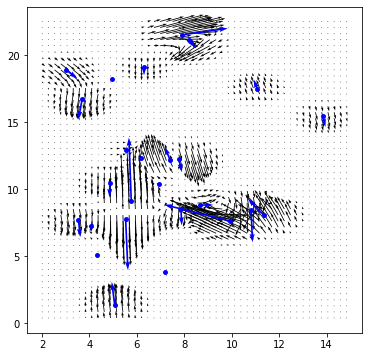

In [20]:
plt.figure(figsize=(6, 6))
plt.quiver(grid_xy[:,0], grid_xy[:,1], intpl_u, intpl_v)
plt.scatter(ini_xy[:,0], ini_xy[:,1], s=15, c='b')
plt.quiver(ini_xy[:,0], ini_xy[:,1], ini_u, ini_v, width=0.005, color='blue')
plt.show()